# MA261 Assignment 3

Student ID: 2106983

---

In [1]:
import numpy as np
def npPrint(a, f={'float_kind':lambda x: "%.5e" % x}): 
   print( np.array2string(a, formatter=f) )
from matplotlib import pyplot as plt
import pandas as pd
from scipy.linalg import expm

## Other functions needed

In [2]:
def newton (F, DF, x0, eps,K):
    k=0
    x=x0
    while (k<K):
        gamma=np.linalg.solve(DF(x),F(x))
        x=x-gamma
        k=k+1
        if np.linalg.norm(F(x))<eps:
            break
            
    if (np.linalg.norm(F(x0))<eps):
        x=x0
        k=0
    return x, k

In [3]:
def evolve(phi, f,Df, t0,y0, T,N):
    n=np.arange(0,N+1,1)
    h=T/N
    t=n*h
    
    y=np.zeros((N+1,len(y0)))
    y[0]=y0
    for i in range(N):
        y[i+1]=phi(f,Df,t[i],y[i],h)
        
    return t,y

In [4]:
def experiment(stepper):
    M    = 10
    N0   = 25
    herr = np.zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], np.linalg.norm(yn-Y(tn)) )

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )

    return res

In [5]:
def computeEocs( herr ):
    m=np.size(herr,0)
    eocs=np.zeros(m-1)
    h=herr[:,0]
    e=herr[:,1]
    for i in range(m-1):
        eocs[i]=(np.log(e[i+1]/e[i])/np.log(h[i+1]/h[i]))
    return eocs

## Q 2.0.

In [6]:
def dirk(f,Df, t0,y0, h, alpha,beta,gamma): 
    m = len(alpha)
    n = len(y0)
    k = np.zeros((m,n))
    y = y0
    for i in range(m):
        sum=0
        for j in range(i):
            sum+=beta[i,j]*k[j]
        def F(x):
            return x-f(t0+alpha[i]*h,y0+h*sum+h*beta[i,i]*x)
        def DF(x):
            return np.eye(n)-Df(t0+alpha[i]*h,y0+h*sum+h*beta[i,i]*x)*h*beta[i,i]
        a,_=newton(F,DF,f(t0,y0),1e-15,1000)
        k[i,]=a
    for i in range (m):    
        y = y + h*gamma[i]*k[i,]
    return y

In [ ]:
def explicitrk(f,Df, t0,y0, h, alpha,beta,gamma): 
    m = len(alpha)
    n = len(y0)
    k = np.zeros((m,n))
    y = y0
    for i in range(m):
        sum=0
        for j in range(i):
            sum=sum+beta[i,j]*k[j]
        k[i,]=f(t0+alpha[i]*h,y0+h*sum)
        y = y + h*gamma[i]*k[i,]
    return y
stepper2 = lambda f,Df,t0,y0,h : dirk(f,Df,t0,y0,h,alpha,beta,gamma)

# Q 2.1.

In [7]:
def f(t,y):
    return np.array([y[1],y[1]*(1-2*y[0])])

def Df(t,y):
    return np.array([[0,1],[-2*y[1],1-2*y[0]]])

def Y(t):
    Y=np.zeros(2)
    Y[0]=2*np.exp(t)/(2*np.exp(t)-1)
    Y[1]=-2*np.exp(t)/((2*np.exp(t)-1)**2)
    return Y

y0=np.array([2,-2])
T=10
N0=25

In [8]:
g = np.array([0.5, 0.5])

a0 = np.array([0., 1.])
b0  = np.array([[0., 0.],[1., 0.]])

stepper0 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,a0,b0,g)

In [9]:
a1 = np.array([0.25, 0.75])
b1  = np.array([[0.25, 0.],[0.5, 0.25]])

stepper1 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,a1,b1,g)

In [10]:
d= 0.5+np.sqrt(3)/6
a2 = np.array([d, 1-d])
b2  = np.array([[d, 0.],[1-2*d, d]])

stepper2 = lambda f,Df,t0,y0,h: dirk(f,Df,t0,y0,h,a2,b2,g)

In [11]:
res0 = experiment(stepper0)
res1 = experiment(stepper1)
res2 = experiment(stepper2)

,h,d=0 error,d=0 eoc,d=1/4 error,d=1/4 eoc,d=1/2+sqrt(3)/6 error,d=1/2+sqrt(3)/6 eoc
0,4.0000e-01,2.336009e-01,nan,1.980478e-02,nan,4.445094e-02,nan
1,2.0000e-01,5.724377e-02,2.029,5.230983e-03,1.921,8.023322e-03,2.470
2,1.0000e-01,1.252991e-02,2.192,1.295326e-03,2.014,1.206824e-03,2.733
3,5.0000e-02,2.894328e-03,2.114,3.279166e-04,1.982,1.694120e-04,2.833
4,2.5000e-02,6.889803e-04,2.071,8.193583e-05,2.001,2.265019e-05,2.903
5,1.2500e-02,1.680073e-04,2.036,2.048125e-05,2.000,2.928069e-06,2.952
6,6.2500e-03,4.148271e-05,2.018,5.120459e-06,2.000,3.724442e-07,2.975
7,3.1250e-03,1.030578e-05,2.009,1.280139e-06,2.000,4.696281e-08,2.987
8,1.5625e-03,2.568356e-06,2.005,3.200344e-07,2.000,5.896118e-09,2.994
9,7.8125e-04,6.410798e-07,2.002,8.000881e-08,2.000,7.386351e-10,2.997


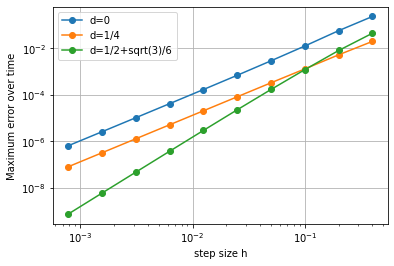

In [12]:
def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n} error', f'{n} eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()


compareErrors({"d=0":res0,"d=1/4":res1,"d=1/2+sqrt(3)/6":res2})

Summary Q2.1
------------

All methods satisfy the conditions for at least linear convergence as the sum of the $\gamma_i$'s is 1. All methods also satisfy the conditions for at least quadratic convergence as the sum of $\alpha_i*\gamma_i$ clearly equals half for all the methods. The methods with d=0 and 1/4 do not satisfy the conditions for convergence of order 3 as the sum of $\alpha_i^2*\gamma_i$ equals half and $5/16$ respectively which is not equal to a third. The method with $d=1/2+sqrt(3)/6$ does satisfy these conditions as the sum of $\alpha_i^2*\gamma_i$ equals a third and the sum of $\gamma_i*\beta_{ij}*\alpha_j$ equals a sixth.

This theory can be seen demonstrated in the table which shows the eocs converging to 2 for the first 2 methods and 3 for the third method.

## Q2.2/3

In [13]:
def experiment(stepper):
    M    = 8
    T    = 100
    N0   = 500
    herr = np.zeros( [M,2] )
    for m in range(M):
        N = N0*2**m
        t,y = evolve( stepper, f,Df, 0,Y(0),T, N)
        herr[m] = [T/N, 0]
        for tn,yn in zip(t,y):
            herr[m][1] = max(herr[m][1], np.linalg.norm(yn-Y(tn)) )

    eoc = computeEocs( herr )
    eoc = np.hstack( [ [np.nan],eoc ] )
    res = np.hstack( [herr, np.atleast_2d(eoc).T] )

    return res

In [14]:
def edirk( F,DF, t0,y0, h, alpha,beta,gamma, exphMs, exphMsInv, exphM):
    m = len(y0)
    s = len(alpha)
    k = np.zeros((s,m))
    y = y0.copy().astype(float)
    for i in range (s):
        sum=0
        for j in range(i):
            sum=sum+beta[i,j]*k[j]
        def H(x):
            return x-exphMsInv[i].dot(F(t0+alpha[i]*h,exphMs[i].dot(y0+h*sum+h*beta[i,i]*x)))
        def DH(x):
            return np.eye(m)-DF(t0+alpha[i]*h,exphMs[i].dot(y0+h*sum+h*beta[i,i]*x))*h*beta[i,i]
        a,_=newton(H,DH,f(t0+alpha[i]*h,y0+h*sum),h*h*1e-5,1000)
        k[i,]=a
    for i in range (m):    
        y = y + h*gamma[i]*k[i,]
    y = exphM.dot(y)
    return y

In [15]:
omega0=4
x0=0.05*np.pi
p0=0

from scipy.special import ellipj , ellipk
k = np.sin(x0/2) # x0: initial condition ellipk(k*k)
K = ellipk(k*k)
def Y(t):
    sn, cn, dn, _ = ellipj(K-omega0*t, k*k)
    x = 2*np.arcsin(k*sn)
    p = 2/np.sqrt(1-(k*sn)**2) * cn*dn * k*(-omega0)
    return np.array([x,p])

def f(t,y):
    return np.array([y[1],-omega0**2*np.sin(y[0])])

def Df(t,y):
    return np.array([[0,1],[-omega0**2*np.cos(y[0]),0]])

def H(y):
    return 0.5*y[1]**2-omega0**2*np.cos(y[0])

def F(t,y):
    return np.array(0,omega0**2*y[0]-omega0**2*np.sin(y[0]))

def DF(t,y):
    return np.array([[0,0],[omega0**2-omega0**2*np.cos(y[0]),0]])

M = np.array([[0., 1.],[-omega0**2, 0]])

y0=Y(0)

In [16]:
stepper3 = lambda f,Df,t0,y0,h: edirk(lambda t,y:f(t,y)-M.dot(y),
                                      lambda t,y:Df(t,y)-M,
                                      t0,y0,h,a1,b1,g,(expm(a1[0]*h*M),expm(a1[1]*h*M)),(expm(-a1[0]*h*M),expm(-a1[1]*h*M)),
                                      expm(h*M))

stepper4 = lambda f,Df,t0,y0,h: edirk(lambda t,y:f(t,y)-M.dot(y),
                                      lambda t,y:Df(t,y)-M,
                                      t0,y0,h,a2,b2,g,(expm(a2[0]*h*M),expm(a2[1]*h*M)),(expm(-a2[0]*h*M),expm(-a2[1]*h*M)),
                                      expm(h*M))

In [17]:
res1 = experiment(stepper1)
res2 = experiment(stepper2)
res3 = experiment(stepper3)
res4 = experiment(stepper4)

In [18]:
T=100
N=1000
h=T/N

HamError11=np.zeros((N+1,2))
t,y=evolve(stepper1,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError11[j,:]=[t[j],Hamerror]


HamError12=np.zeros((N+1,2))
t,y=evolve(stepper2,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError12[j,:]=[t[j],Hamerror]
            
HamError13=np.zeros((N+1,2))
t,y=evolve(stepper3,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError13[j,:]=[t[j],Hamerror]


HamError14=np.zeros((N+1,2))
t,y=evolve(stepper4,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError14[j,:]=[t[j],Hamerror]

In [19]:
N=4000
h=T/N

HamError31=np.zeros((N+1,2))
t,y=evolve(stepper1,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError31[j,:]=[t[j],Hamerror]


HamError32=np.zeros((N+1,2))
t,y=evolve(stepper2,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError32[j,:]=[t[j],Hamerror]
            
HamError33=np.zeros((N+1,2))
t,y=evolve(stepper3,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError33[j,:]=[t[j],Hamerror]


HamError34=np.zeros((N+1,2))
t,y=evolve(stepper4,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError34[j,:]=[t[j],Hamerror]

First initial conditions


,h,d=1/4 error,d=1/4 eoc,d=1/2+sqrt(3)/6 error,d=1/2+sqrt(3)/6 eoc,d=1/4 exp error,d=1/4 exp eoc,d=1/2+sqrt(3)/6 exp error,d=1/2+sqrt(3)/6 exp eoc
0,2.0000e-01,1.251875e+00,nan,6.537392e-01,nan,1.028547e-04,nan,1.951670e-04,nan
1,1.0000e-01,7.578249e-01,0.724,5.406771e-01,0.274,2.479629e-05,2.052,2.946011e-05,2.728
2,5.0000e-02,2.055128e-01,1.883,1.549727e-01,1.803,6.198332e-06,2.000,3.613867e-06,3.027
3,2.5000e-02,5.162042e-02,1.993,2.411841e-02,2.684,1.471008e-06,2.075,4.572883e-07,2.982
4,1.2500e-02,1.292104e-02,1.998,3.176289e-03,2.925,3.627161e-07,2.020,5.389404e-08,3.085
5,6.2500e-03,3.230648e-03,2.000,4.037486e-04,2.976,9.041270e-08,2.004,7.162137e-09,2.912
6,3.1250e-03,8.076770e-04,2.000,5.081873e-05,2.990,2.258339e-08,2.001,9.323216e-10,2.941
7,1.5625e-03,2.019200e-04,2.000,6.372840e-06,2.995,5.641976e-09,2.001,1.223321e-10,2.930


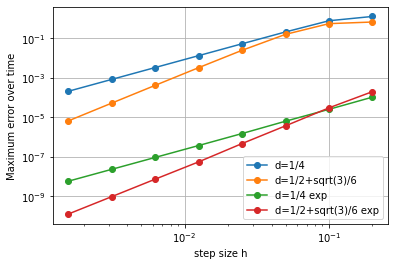

/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:33: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError11[:,0],np.log(HamError11[:,1]),label="d=1/4")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:34: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError12[:,0],np.log(HamError12[:,1]),label="d=1/2+sqrt(3)/6")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:35: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError13[:,0],np.log(HamError13[:,1]),label="d=1/4 exp")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:36: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError14[:,0],np.log(HamError14[:,1]),label="d=1/2+sqrt(3)/6 exp")


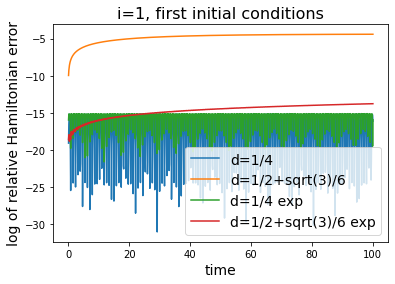

/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:43: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError31[:,0],np.log(HamError31[:,1]),label="d=1/4")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:44: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError32[:,0],np.log(HamError32[:,1]),label="d=1/2+sqrt(3)/6")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:45: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError33[:,0],np.log(HamError33[:,1]),label="d=1/4 exp")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3780672043.py:46: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError34[:,0],np.log(HamError34[:,1]),label="d=1/2+sqrt(3)/6 exp")


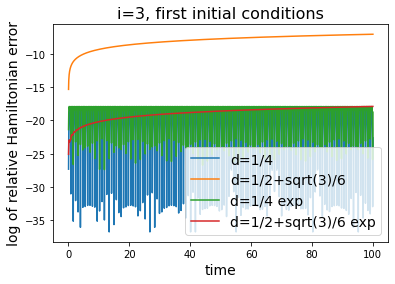

In [20]:
def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n} error', f'{n} eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()

print("First initial conditions")
compareErrors({"d=1/4":res1,"d=1/2+sqrt(3)/6":res2,"d=1/4 exp":res3,"d=1/2+sqrt(3)/6 exp":res4})

plt.plot(HamError11[:,0],np.log(HamError11[:,1]),label="d=1/4")
plt.plot(HamError12[:,0],np.log(HamError12[:,1]),label="d=1/2+sqrt(3)/6")
plt.plot(HamError13[:,0],np.log(HamError13[:,1]),label="d=1/4 exp")
plt.plot(HamError14[:,0],np.log(HamError14[:,1]),label="d=1/2+sqrt(3)/6 exp")
plt.title("i=1, first initial conditions", fontsize=16)
plt.xlabel("time", fontsize=14)
plt.ylabel("log of relative Hamiltonian error", fontsize=14)
plt.legend(fontsize=14)
plt.show()   

plt.plot(HamError31[:,0],np.log(HamError31[:,1]),label="d=1/4")
plt.plot(HamError32[:,0],np.log(HamError32[:,1]),label="d=1/2+sqrt(3)/6")
plt.plot(HamError33[:,0],np.log(HamError33[:,1]),label="d=1/4 exp")
plt.plot(HamError34[:,0],np.log(HamError34[:,1]),label="d=1/2+sqrt(3)/6 exp")
plt.title("i=3, first initial conditions", fontsize=16)
plt.xlabel("time", fontsize=14)
plt.ylabel("log of relative Hamiltonian error", fontsize=14)
plt.legend(fontsize=14)
plt.show()   

In [21]:
x0=0.6*np.pi
p0=0

from scipy.special import ellipj , ellipk
k = np.sin(x0/2) # x0: initial condition ellipk(k*k)
K = ellipk(k*k)
def Y(t):
    sn, cn, dn, _ = ellipj(K-omega0*t, k*k)
    x = 2*np.arcsin(k*sn)
    p = 2/np.sqrt(1-(k*sn)**2) * cn*dn * k*(-omega0)
    return np.array([x,p])

y0=Y(0)

In [22]:
res1 = experiment(stepper1)
res2 = experiment(stepper2)
res3 = experiment(stepper3)
res4 = experiment(stepper4)

In [23]:
T=100
N=1000
h=T/N

HamError11=np.zeros((N+1,2))
t,y=evolve(stepper1,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError11[j,:]=[t[j],Hamerror]


HamError12=np.zeros((N+1,2))
t,y=evolve(stepper2,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError12[j,:]=[t[j],Hamerror]
            
HamError13=np.zeros((N+1,2))
t,y=evolve(stepper3,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError13[j,:]=[t[j],Hamerror]


HamError14=np.zeros((N+1,2))
t,y=evolve(stepper4,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError14[j,:]=[t[j],Hamerror]

In [24]:
N=4000
h=T/N

HamError31=np.zeros((N+1,2))
t,y=evolve(stepper1,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError31[j,:]=[t[j],Hamerror]


HamError32=np.zeros((N+1,2))
t,y=evolve(stepper2,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError32[j,:]=[t[j],Hamerror]
            
HamError33=np.zeros((N+1,2))
t,y=evolve(stepper3,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError33[j,:]=[t[j],Hamerror]


HamError34=np.zeros((N+1,2))
t,y=evolve(stepper4,f,Df,0,y0,T,N)
for j in range(np.shape(y)[0]):
            Hamerror=np.linalg.norm(H(y[j])-H(y0))/np.linalg.norm(H(y0))
            HamError34[j,:]=[t[j],Hamerror]

Second initial conditions


,h,d=1/4 error,d=1/4 eoc,d=1/2+sqrt(3)/6 error,d=1/2+sqrt(3)/6 eoc,d=1/4 exp error,d=1/4 exp eoc,d=1/2+sqrt(3)/6 exp error,d=1/2+sqrt(3)/6 exp eoc
0,2.0000e-01,2.601630e+00,nan,1.004820e+01,nan,1.020253e+01,nan,3.364261e+07,nan
1,1.0000e-01,6.420973e-01,2.019,1.177285e+01,-0.229,2.779512e+00,1.876,9.229291e+01,18.476
2,5.0000e-02,1.607761e-01,1.998,1.256500e+01,-0.094,7.100342e-01,1.969,1.333386e+01,2.791
3,2.5000e-02,4.011672e-02,2.003,9.939796e+00,0.338,1.779034e-01,1.997,5.256166e+00,1.343
4,1.2500e-02,1.002939e-02,2.000,1.349607e+00,2.881,4.449222e-02,1.999,6.694420e-01,2.973
5,6.2500e-03,2.507098e-03,2.000,1.702809e-01,2.987,1.112363e-02,2.000,8.354653e-02,3.002
6,3.1250e-03,6.267770e-04,2.000,2.130899e-02,2.998,2.781082e-03,2.000,1.044190e-02,3.000
7,1.5625e-03,1.566930e-04,2.000,2.664240e-03,3.000,6.952713e-04,2.000,1.305297e-03,3.000


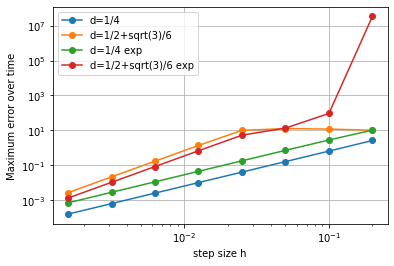

/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:33: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError11[:,0],np.log(HamError11[:,1]),label="d=1/4")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:34: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError12[:,0],np.log(HamError12[:,1]),label="d=1/2+sqrt(3)/6")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:35: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError13[:,0],np.log(HamError13[:,1]),label="d=1/4 exp")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:36: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError14[:,0],np.log(HamError14[:,1]),label="d=1/2+sqrt(3)/6 exp")


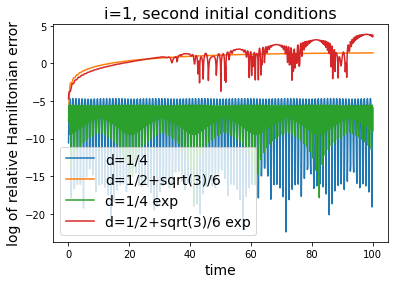

/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:43: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError31[:,0],np.log(HamError31[:,1]),label="d=1/4")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:44: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError32[:,0],np.log(HamError32[:,1]),label="d=1/2+sqrt(3)/6")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:45: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError33[:,0],np.log(HamError33[:,1]),label="d=1/4 exp")
/var/folders/6m/d_m06xzj59bctjxjdqwpp04m0000gn/T/ipykernel_49887/3236054184.py:46: RuntimeWarning: divide by zero encountered in log
  plt.plot(HamError34[:,0],np.log(HamError34[:,1]),label="d=1/2+sqrt(3)/6 exp")


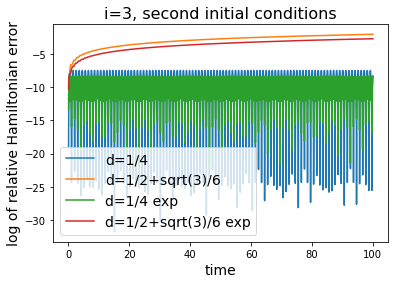

In [25]:
def compareErrors(results):
    # columns of table
    simul = list(results.keys())
    columns=['h'] + [s for n in simul for s in [f'{n} error', f'{n} eoc']]
    # values in tablea
    keys   = {columns[0]: results[simul[0]][:,0]} # all results are assumed to use the same sequence of h
    styles = {columns[0]: '{:.4e}'}
    for i, k in enumerate(simul):
        keys[columns[2*i+1]]   = results[k][:,1] # errors
        styles[columns[2*i+1]] = '{:.6e}'
        keys[columns[2*i+2]]   = results[k][:,2] # eocs
        styles[columns[2*i+2]] = '{:.3f}'

    # generate table
    table = pd.DataFrame(keys, index=range(results[simul[0]].shape[0]), # all results must have the same shape
            columns=columns)

    # format floating points for each column for jupyter output (does not work in pdf)
    display( table.style.format(styles) )

    for i,k in enumerate(simul):
        plt.loglog(results[k][:,0],results[k][:,1],marker='o',label=k)
    plt.legend()
    plt.grid(True)
    plt.xlabel("step size h")
    plt.ylabel("Maximum error over time")
    plt.savefig("Q2_compareErr.pdf", format="pdf", bbox_inches="tight") # output to pdf for inclusing in tex document
    plt.show()

print("Second initial conditions")
compareErrors({"d=1/4":res1,"d=1/2+sqrt(3)/6":res2,"d=1/4 exp":res3,"d=1/2+sqrt(3)/6 exp":res4})

plt.plot(HamError11[:,0],np.log(HamError11[:,1]),label="d=1/4")
plt.plot(HamError12[:,0],np.log(HamError12[:,1]),label="d=1/2+sqrt(3)/6")
plt.plot(HamError13[:,0],np.log(HamError13[:,1]),label="d=1/4 exp")
plt.plot(HamError14[:,0],np.log(HamError14[:,1]),label="d=1/2+sqrt(3)/6 exp")
plt.title("i=1, second initial conditions", fontsize=16)
plt.xlabel("time", fontsize=14)
plt.ylabel("log of relative Hamiltonian error", fontsize=14)
plt.legend(fontsize=14)
plt.show()   

plt.plot(HamError31[:,0],np.log(HamError31[:,1]),label="d=1/4")
plt.plot(HamError32[:,0],np.log(HamError32[:,1]),label="d=1/2+sqrt(3)/6")
plt.plot(HamError33[:,0],np.log(HamError33[:,1]),label="d=1/4 exp")
plt.plot(HamError34[:,0],np.log(HamError34[:,1]),label="d=1/2+sqrt(3)/6 exp")
plt.title("i=3, second initial conditions", fontsize=16)
plt.xlabel("time", fontsize=14)
plt.ylabel("log of relative Hamiltonian error", fontsize=14)
plt.legend(fontsize=14)
plt.show()   

## Q2.2/3 Summary

For initial conditions $(0.05\pi,0)$ in the table and plot it can be seen that the errors of the exponentially fit DIRK methods are much lower than the regular fit methods and generally for both methods with $d=0.788$ has lower errors than $d=0.25$. For the exponentially fit methods there is a point where the lines on the plot cross so for larger $h$m $d=0.25$ acc has lower error but very quickly $d=0.788$ starts to have lower error. The eocs for regular fit $d=0.25$, regular fit $d=0.788$, exponentially fit $d=1/4$ exponentially fit $d=0.788$ converge to 2,3,2 and 3  respectively which is what we expect given the order conditions that each method satisfies. 

Finally when looking at the hamiltonian error it can be seen that the methods with $d=0.788$ have larger error with the regular fit method having the largest error by quite a lot. The exponentially fit method has errors much closer to the errors of the methods with $d=1/4$ but it is always increasing whereas the errors of the methods with $d=1/4$ are constantly below a certain value and vary how far below this value they get. The errors for the regular fit method with $d=1/4$ are generally always less than the errors for the exponentially fit method so this method actually conserves the hamiltonian the best. As we saw in 1.3(1) all methods conserve any linear invariant and from 1.3(3) the methods with d=1/4 conserve quadratic invariants.

For the second initial conditions $(0.6\pi,0)$ the methods with $d=1/4$ have the lowest errors and seem to follow a linear pattern. The methods with $d=0.788$ follow a similar pattern below a certain value of h but always with larger errors. Above the critical value of h about $0.05$ the errors of the regular fit method start to decrease and there is a large increase in the methods of the exponentially fit method which are both unusual observations. Again we see that the eocs converge to 2,3,2,3 as expected.

For the hamiltonian error, we see a mostly similar pattern to the first initial conditions but in this context the errors for the different methods with $d=0.788$ are much closer and similarly the errors for the methods with $d=0.25$ are much closer to the errors of the methods with $d=0.788$. However we see the same pattern that the exponentially fit method for $d=0.788$ has lower errors than the regular fit and generally the regular fit for $d=0.25$ has lower errors than the exponentially fit.